# Ex13 CIFAR-10 이미지 생성하기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
from keras.layers import GaussianNoise
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


## CIFAR-10 데이타 로딩하기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170500096/170498071 [==============================] - 2s 0us/step


(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


## 데이터 정규화하기.

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

## 데이터 샘플 출력해보기

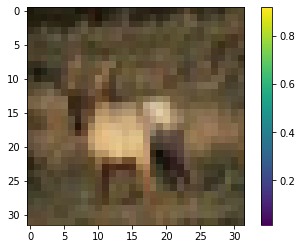

In [6]:
plt.imshow((train_x[3]+1)/2)
plt.colorbar()
plt.show()

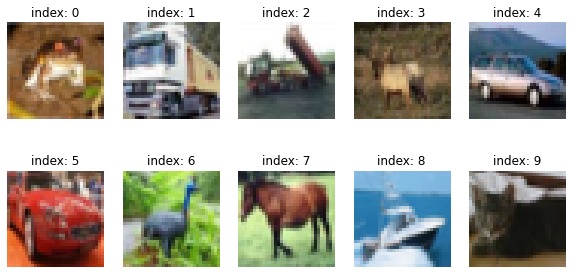

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i]+1)/2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

## 미니 배치 데이터셋 구성하기

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 생성자 모델 구현하기

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(GaussianNoise( stddev=0.1 ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 512)))
    
    
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(GaussianNoise( stddev=0.1 ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(GaussianNoise( stddev=0.1 ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(GaussianNoise( stddev=0.1 ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
gaussian_noise (GaussianNois (None, 32768)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 8, 8, 256)         0

In [12]:
noise = tf.random.normal([1, 100])

In [13]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

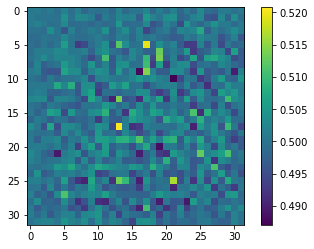

In [14]:
plt.imshow(((generated_image[0, :, :, 0])+1)/2)
plt.colorbar()
plt.show()

## 판별자 모델 구현하기

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00124587]], dtype=float32)>

## 손실함수 구현하기

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## 정확도 함수 구현

In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 최적화함수 설정

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=4e-4,beta_1=0.5)

## 샘플 설정

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## Train step 함수 구현


In [24]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [25]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/02/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [26]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/02/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [27]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/02/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Train 함수 구현

In [28]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [29]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 훈련 및 훈련결과 확인

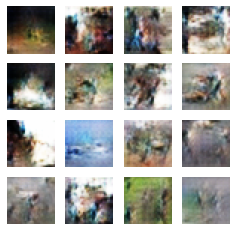

Time for training : 3013 sec


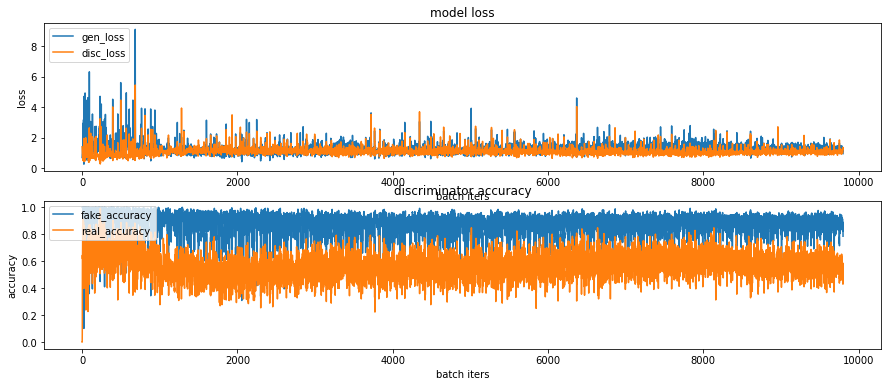

CPU times: user 36min 29s, sys: 13min 39s, total: 50min 8s
Wall time: 50min 14s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)


In [31]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/02/cifar_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/02/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)



## 초기버전 결과

* 초기 세팅으로 나온결과 사진

![test](https://github.com/viva68/aiffel_project/blob/master/Ex13/sample_epoch_0050_iter_195-ori.png?raw=true)

* 형상을 알아보기 힘듭니다.

* gif 파일 출력

* gif가 github 주피터 노트북에서는 잘안됩니다 ㅠㅠ 링크로 봐주세요

링크:https://github.com/viva68/aiffel_project/blob/master/Ex13/cifar_dcgan_ori.gif

![Alt Text](https://i.postimg.cc/hP1WVxJC/cifar-dcgan-ori.gif)

* 그래프

![test](https://github.com/viva68/aiffel_project/blob/master/Ex13/train_history_0049_ori.png?raw=true)
<br>

## 개선안 적용하기

## learning rate 조정하기
* 참고 article 3에서 adam의 학습률를 0.0002 그리고 모멘텀(beta1)을 0.5로 주는 것이 안정적인 학습에 도움이된다고함.
* 참고 article 2에서는 생성자와 판별자의 학습률이 다른 것이 유리하며 저자는 판별자를  0.0004, 생성자를 0.0001을 자주 선택한다고함.
* 따라서 두아티클을 적용해 판별자는 학습률 0.0004 모멘텀 0.5, 생성자는 0.0002 모멘텀 0.5로 선택함.

## 결과

![test](https://github.com/viva68/aiffel_project/blob/master/Ex13/sample_epoch_0050_iter_195_lr.png?raw=true)
<br>

* 1행 2열에 닭사진만 알아볼 수 있었습니다.

* gif 파일 출력

* gif가 github 주피터 노트북에서는 잘안됩니다 ㅠㅠ 링크로 봐주세요

링크:https://github.com/viva68/aiffel_project/blob/master/Ex13/cifar_dcgan_lr.gif

![Alt Text](https://i.postimg.cc/zXXpPRt2/cifar-dcgan-lr.gif)


* loss accuracy 그래프결과

![test](https://github.com/viva68/aiffel_project/blob/master/Ex13/train_history_0049_lr.png?raw=true)
<br>

## 깊은 레이어 쌓기 및 drop out 계수 높이기

* 조금 더 개선하기 위해 좀더 많은 특징을 볼 수 있도록 생성자와 판별자의 layer를 한층더 쌓았습니다.
* 참고 article 1에서 dropout 계수를 0.5로하면 개선된다 하여 판별자의 dropout 계수를 0.5로 올렸습니다.

## 결과

* png 결과

<img src="./sample_epoch_0050_iter_195_layer.png">
<br>

* 1행 1열에 쥐사진 4열 2행에 토끼사진 2열 3행에 개구리사진정도 알아볼 수 있었습니다.

* gif 결과

* gif가 github 주피터 노트북에서는 잘안됩니다 ㅠㅠ 링크로 봐주세요

링크:https://github.com/viva68/aiffel_project/blob/master/Ex13/cifar_dcgan_layer.gif

![Alt Text](https://i.postimg.cc/PxVNX9Hw/cifar-dcgan-layer.gif)

* loss accuracy 결과

![test](https://github.com/viva68/aiffel_project/blob/master/Ex13/train_history_0049_layer.png?raw=true)
<br>

## gaussian noise 넣어보기

* 참고 1 article에서 생성자의 모든 레이어에 가우시안 노이즈를 넣으면 개선된다고하여 넣어봤습니다.

* png 결과

![test](https://github.com/viva68/aiffel_project/blob/master/Ex13/sample_epoch_0050_iter_195_filter.png?raw=true)
<br>

* 어느사진도 알아보기 힘들었습니다.

* gif 결과

* gif가 github 주피터 노트북에서는 잘안됩니다 ㅠㅠ 링크로 봐주세요

링크:https://github.com/viva68/aiffel_project/blob/master/Ex13/cifar_dcgan_filter.gif

![Alt Text](https://i.postimg.cc/PxVNX9Hw/cifar-dcgan-filter.gif)

* 어느하나 알아보기 힘들었습니다.

* loss, accuracy 결과

![test](https://github.com/viva68/aiffel_project/blob/master/Ex13/train_history_0049_filter.png?raw=true)
<br>

# 회고

* 노드와 설정을 그대로 했을 경우 사진이 무엇인지 알아볼 수 없었고 accuracy는 0.6~0.7 사이에 수렴하는것을 볼 수 있었습니다.
* 1차 개선안은 learning rate를 article을 참조해 변경했습니다. 1행 2열에 닭사진 하나정도 알아볼 수 있었고 나머지는 알 수 없었습니다. accuracy는 0.5~0.4 사이에 수렴하는것을 볼 수 있었습니다. 초기 설정보다 개선된 것을 볼 수 있었습니다.
* 2차 개선안은 생성자와 판별자의 layer를 1층 늘렸으며 article을 참조해 drop out 계수를 올렸습니다. 그러니 1행 1열에 쥐사진 4열 2행에 토끼사진 2열 3행에 개구리사진정도 알아볼 수 있었습니다. 0.5~0.4 사이에 수렴하는것을 볼 수 있었습니다. 1차 개선안보다 개선된 것을 알수 있었습니다.
* 3차 개선안은 생성자의 각레이어에 article을 참조해 gaussian 필터를 넣었습니다. 계수를 여러번 바꾸면서 시도했으나 아웃풋들은 형체를 알아보기 힘들었습니다. 결과가 더 퇴화됐습니다. 지금까지 기존 개선안에 새 개선안을 추가하는 방식으로 개선했는데 가우시안 필터는 필터 하나만 적용할 때 효과가 있는 것 같아 보입니다. 

* 어려웠던점은 article에 여러가지 개선안에 대한 설명이 있었으나 이해가 어려운 방법들은 적용을 못했습니다. 그리고 결과를 더 좋게 하려했으나 cifar 사진 자체가 화질이 안좋아서 gan 결과도 화질이 안좋을 수 밖에 없다고 생각하게 됐습니다. 인풋 화질을 좋게하고 layer를 더 깊게 쌓고 개선안을 적용하면 더 좋은 결과를 얻을 수 있었다고 생각합니다.